In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = "/content/drive/MyDrive/rice-leaf-disease/training"

dataset = []
label = 0

for file in os.listdir(data_dir):
    path = os.path.join(data_dir, file)
    for img in os.listdir(path):
        image = load_img(os.path.join(path, img), grayscale=False, color_mode='rgb', target_size=(32,32))
        image = img_to_array(image)
        image = image/255.0
        dataset += [[image, label]]
    label+=1

print('There are', len(dataset), 'images in', label, 'classes')

There are 16160 images in 4 classes


In [4]:
data, labels = zip(*dataset)
data = np.array(data)
labels = np.array(to_categorical(labels))

train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=44)

print(train_data.shape)
print(val_data.shape)
print(train_labels.shape)
print(val_labels.shape)

(12928, 32, 32, 3)
(3232, 32, 32, 3)
(12928, 4)
(3232, 4)


In [5]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=20,
                                   zoom_range=0.1,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   fill_mode="nearest")

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1024, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 128)               1

In [7]:
history = model.fit(train_datagen.flow(train_data, train_labels, batch_size=100),
                    validation_data=(val_data, val_labels),
                    epochs=30)

Epoch 1/30
130/130 [==============================] - 20s 145ms/step - loss: 0.8880 - accuracy: 0.5630 - val_loss: 0.4983 - val_accuracy: 0.8029
Epoch 2/30
130/130 [==============================] - 21s 158ms/step - loss: 0.4776 - accuracy: 0.8093 - val_loss: 0.2789 - val_accuracy: 0.8942
Epoch 3/30
130/130 [==============================] - 19s 142ms/step - loss: 0.3330 - accuracy: 0.8695 - val_loss: 0.1847 - val_accuracy: 0.9264
Epoch 4/30
130/130 [==============================] - 18s 141ms/step - loss: 0.2697 - accuracy: 0.8939 - val_loss: 0.1809 - val_accuracy: 0.9288
Epoch 5/30
130/130 [==============================] - 18s 141ms/step - loss: 0.2174 - accuracy: 0.9158 - val_loss: 0.1574 - val_accuracy: 0.9412
Epoch 6/30
130/130 [==============================] - 19s 143ms/step - loss: 0.2034 - accuracy: 0.9209 - val_loss: 0.1896 - val_accuracy: 0.9313
Epoch 7/30
130/130 [==============================] - 19s 143ms/step - loss: 0.1673 - accuracy: 0.9330 - val_loss: 0.1716 - val_ac

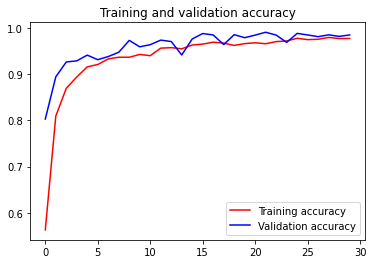

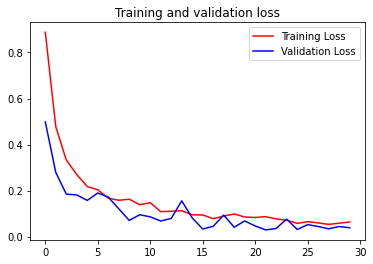

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
export_dir = '/content/drive/MyDrive/PadE/saved_model'
tf.saved_model.save(model,export_dir=export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PadE/saved_model/assets


In [10]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert();
tflite_model_file = pathlib.Path('/content/drive/MyDrive/PadE/saved_model/model.tflite')
tflite_model_file.write_bytes(tflite_model)

859168